In [1]:
!pip install seaborn
!pip install matplotlib

     |████████████████████████████████| 215 kB 8.3 MB/s eta 0:00:01


In [2]:
import os
import glob
import re
import pandas as pd
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
from more_itertools import chunked

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%pwd
%cd /workspace/oid2yolo_proj

/workspace/oid2yolo_proj


In [4]:
oid_path = "./oid"

In [5]:
oid_class_csv = oid_path + '/class-descriptions-boxable.csv'

class_names = ['Human face', 'Vehicle registration plate']
df_all_classes = pd.read_csv(oid_class_csv, names=['LabelName', 'ClassName'])
df_classes = df_all_classes[df_all_classes['ClassName'].isin(class_names)].copy()
df_classes['order'] = df_classes['ClassName'].apply(lambda x: class_names.index(x))
df_classes.sort_values('order', inplace=True)
df_classes.reset_index(drop=True, inplace=True)
df_classes.drop(columns='order', inplace=True)

In [6]:
org_train_csv = oid_path + '/oidv6-train-annotations-bbox.csv'
org_val_csv = oid_path + '/validation-annotations-bbox.csv'
org_test_csv = oid_path + '/test-annotations-bbox.csv'

In [51]:
class_filter_all =  [
    ["Vehicle registration plate"],
    ["Human face", "Car"],
    ["Human face", "Vehicle"],
    ["Human face", "Land vehicle"],
    ["Human face", "Truck"],
    ["Human face", "Bus"],
    ["Human face", "Van"],
    ["Human face", "Ambulance"],
    ["Human face", "Limousine"],
    ["Human face", "Taxi"],
    ["Human face", "Bicycle"],
    ["Human face", "Bicycle wheel"],
    ["Human face", "Bicycle helmet"],
    ["Human face", "Motorcycle"],
    ["Human face", "Golf cart"],
    ["Human face", "Traffic light"],
    ["Human face", "Traffic sign"],
    ["Human face", "Stop sign"],
    ["Human face", "Parking meter"],
    ["Human face", "Cart"],
    ["Human face", "Street light"],
    ["Human face", "Unicycle"],
    ["Human face", "Skateboard"],
    ["Human face", "Wheel"],
    ["Human face", "Wheelchair"],
    ["Human face", "Billboard"],
    ["Human face", "Carnivore"],
    ["Human face", "Fire hydrant"],
    ["Human face", "Office building"],
    ["Human face", "Hiking equipment"],
    ["Human face", "Stretcher"],
    ["Human face", "Roller skates"],
    ["Human face", "Sun hat"],
    ["Human face", "Helmet"],
    ["Human face", "Sunglasses"],
    ["Human face", "Mobile phone"],
    ["Human face", "Briefcase"],
    ["Human face", "Picnic basket"],
    ["Human face", "Bench"]
]

In [52]:
def split_last_df_image(df):
    df_image = df.groupby("ImageID")
    last_image_id = df.tail(1)["ImageID"]
    last_group = df_image.get_group(*last_image_id)
    last_group_len = len(last_group)
    if last_group_len < len(df):
        df.drop(df.tail(last_group_len).index, inplace=True)
    df_rest = last_group
    return df, df_rest

In [53]:
def flatten_list(l):
    for el in l:
        if isinstance(el, list):
            yield from flatten_list(el)
        else:
            yield el

In [54]:
def image_filter_func(df, class_filter_list):
    for class_filter in class_filter_list:
        if set(class_filter).issubset(list(df["ClassName"])):
            return df[df['ClassName'].isin(flatten_list(class_filter_list))]
    return None

In [55]:
def apply_image_filter(df, class_filter_list, df_class):
    df['ClassName'] = df['LabelName'].agg(lambda x: df_class.loc[df_class[df_class['LabelName'] == x].index[0], "ClassName"])
    return df.groupby("ImageID", as_index=False).apply(image_filter_func, class_filter_list=class_filter_list)

In [56]:
def read_csv_chunk(csv_file, df_classes):
    futures = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        use_columns = ["ImageID", "LabelName"]
        df_rest = None
        for index, df_bbox in enumerate(pd.read_csv(csv_file, header=0, usecols=use_columns, chunksize=10000)):
            df, df_last = split_last_df_image(df_bbox)
            if df_rest is not None:
                df = pd.concat([df_rest, df])
            df_rest = df_last
            future = executor.submit(apply_image_filter, df, class_filter_all, df_classes)
            futures.append(future)
    concurrent.futures.wait(futures, timeout=None)
    df_list = [future.result() for future in concurrent.futures.as_completed(futures)]
    df_csv_all = pd.DataFrame(data=None)
    for df in df_list:
        df_csv_all = pd.concat([df_csv_all, df])
    return df_csv_all

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
_pickle.PicklingError: Can't pickle <function apply_image_filter at 0x7fe23dfbe6a8>: it's not the same object as __main__.apply_image_filter
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
_pickle.PicklingError: Can't pickle <function apply_image_filter at 0x7fe23dfbe6a8>: it's not the same object as __main__.apply_image_filter
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/opt/conda/lib/python3.6

In [45]:
df_org_train = read_csv_chunk(org_train_csv, df_all_classes)
df_org_val = read_csv_chunk(org_val_csv, df_all_classes)
df_org_test = read_csv_chunk(org_test_csv, df_all_classes)

KeyboardInterrupt: 

In [ ]:
display(df_org_train["ClassName"].value_counts())
display(df_org_train["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_train.index.unique())}")

In [ ]:
display(df_org_val["ClassName"].value_counts())
display(df_org_val["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_val.index.unique())}")

In [ ]:
display(df_org_test["ClassName"].value_counts())
display(df_org_test["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_test.index.unique())}")

In [ ]:
sns.catplot(data=df, x="ClassName", kind="count")
plt.show()

In [43]:
need_columns = ["ImageID", "LabelName"]
df_org_train = pd.read_csv(org_train_csv, header=0, usecols=need_columns)
df_org_train['ClassName'] = df_org_train['LabelName'].agg(
    lambda x: df_all_classes.loc[df_all_classes[df_all_classes['LabelName'] == x].index[0], "ClassName"])

Wheel                         1999
Car                           1470
Tire                          1020
Vehicle registration plate     987
Human face                     675
Land vehicle                   306
Vehicle                        224
Helmet                         131
Sunglasses                     106
Bicycle wheel                   59
Taxi                            45
Sun hat                         42
Van                             30
Bicycle helmet                  28
Bicycle                         27
Bus                             17
Truck                           16
Wheelchair                      15
Motorcycle                      15
Roller skates                   14
Mobile phone                    11
Traffic light                   10
Ski                              9
Hiking equipment                 9
Boat                             7
Office building                  7
Street light                     5
Billboard                        5
Skateboard          

Wheel                         0.272901
Car                           0.200683
Tire                          0.139249
Vehicle registration plate    0.134744
Human face                    0.092150
Land vehicle                  0.041775
Vehicle                       0.030580
Helmet                        0.017884
Sunglasses                    0.014471
Bicycle wheel                 0.008055
Taxi                          0.006143
Sun hat                       0.005734
Van                           0.004096
Bicycle helmet                0.003823
Bicycle                       0.003686
Bus                           0.002321
Truck                         0.002184
Wheelchair                    0.002048
Motorcycle                    0.002048
Roller skates                 0.001911
Mobile phone                  0.001502
Traffic light                 0.001365
Ski                           0.001229
Hiking equipment              0.001229
Boat                          0.000956
Office building          

the number of images: 7325


In [ ]:
display(df_org_test["ClassName"].value_counts())
display(df_org_test["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_org_test.index.unique())}")

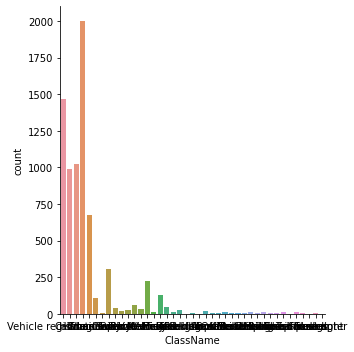

In [44]:
sns.catplot(data=df, x="ClassName", kind="count")
plt.show()

In [ ]:
need_columns = ["ImageID", "LabelName"]
df_org_train = pd.read_csv(org_train_csv, header=0, usecols=need_columns)
df_org_train['ClassName'] = df_org_train['LabelName'].agg(
    lambda x: df_all_classes.loc[df_all_classes[df_all_classes['LabelName'] == x].index[0], "ClassName"])

In [ ]:
display(df_oid_all["ClassName"].value_counts())
display(df_oid_all["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_all.index.unique())}")

In [14]:
oid_train_csv = oid_path + '/oidv6-train-annotations-bbox_selected.csv'
oid_val_csv = oid_path + '/validation-annotations-bbox_selected.csv'
oid_test_csv = oid_path + '/test-annotations-bbox_selected.csv'

In [27]:
df_oid_train = pd.read_csv(oid_train_csv, header=0)
df_oid_train['set'] = 'train'
df_oid_val = pd.read_csv(oid_val_csv, header=0)
df_oid_val['set'] = 'val'
df_oid_test = pd.read_csv(oid_test_csv, header=0)
df_oid_test['set'] = 'test'
df_oid_all = pd.concat([df_oid_train, df_oid_val, df_oid_test])

df_oid_all['ClassName'] = df_oid_all['LabelName'].agg(
    lambda x: df_classes.loc[df_classes[df_classes['LabelName'] == x].index[0], "ClassName"])

In [28]:
class_order = ["Human face", "Vehicle registration plate"]

Human face                    53393
Vehicle registration plate    11682
Name: ClassName, dtype: int64

Human face                    0.820484
Vehicle registration plate    0.179516
Name: ClassName, dtype: float64

the number of images: 28929


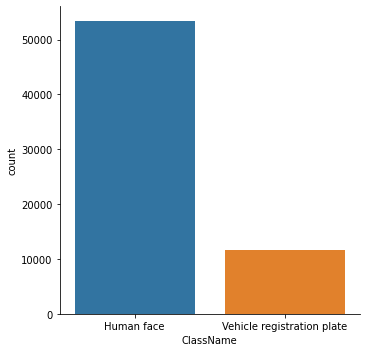

In [29]:
df_oid_all = df_oid_all.set_index("ImageID")
display(df_oid_all["ClassName"].value_counts())
display(df_oid_all["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_all.index.unique())}")
sns.catplot(data=df_oid_all, x="ClassName", kind="count", order=class_order)
plt.show()

Human face                    45043
Vehicle registration plate     7852
Name: ClassName, dtype: int64

Human face                    0.851555
Vehicle registration plate    0.148445
Name: ClassName, dtype: float64

the number of images: 22680


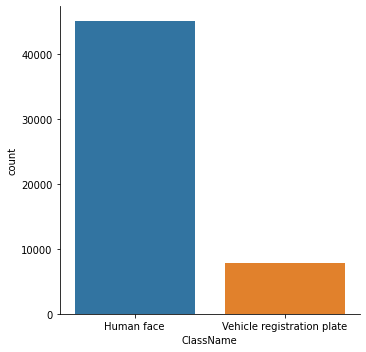

In [30]:
df_oid_train = df_oid_all[df_oid_all["set"] == "train"]
display(df_oid_train["ClassName"].value_counts())
display(df_oid_train["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_train.index.unique())}")
sns.catplot(data=df_oid_train, x="ClassName", kind="count", order=class_order)
plt.show()

Vehicle registration plate    987
Human face                    460
Name: ClassName, dtype: int64

Vehicle registration plate    0.682101
Human face                    0.317899
Name: ClassName, dtype: float64

the number of images: 966


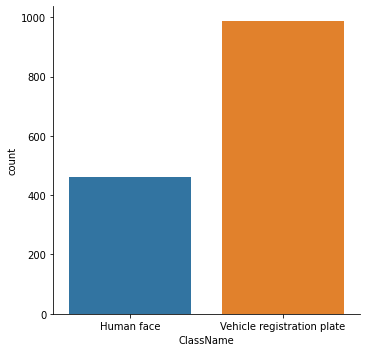

In [31]:
df_oid_val = df_oid_all[df_oid_all["set"] == "val"]
display(df_oid_val["ClassName"].value_counts())
display(df_oid_val["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_val.index.unique())}")
sns.catplot(data=df_oid_val, x="ClassName", kind="count", order=class_order)
plt.show()

Human face                    45503
Vehicle registration plate     8839
Name: ClassName, dtype: int64

Human face                    0.837345
Vehicle registration plate    0.162655
Name: ClassName, dtype: float64

the number of images: 23646


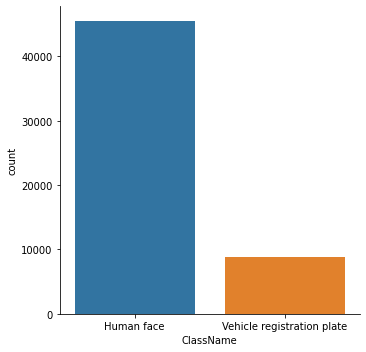

In [32]:
df_oid_train_val = pd.concat([df_oid_train, df_oid_val])
display(df_oid_train_val["ClassName"].value_counts())
display(df_oid_train_val["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_train_val.index.unique())}")
sns.catplot(data=df_oid_train_val, x="ClassName", kind="count", order=class_order)
plt.show()

Human face                    7890
Vehicle registration plate    2843
Name: ClassName, dtype: int64

Human face                    0.735116
Vehicle registration plate    0.264884
Name: ClassName, dtype: float64

the number of images: 5283


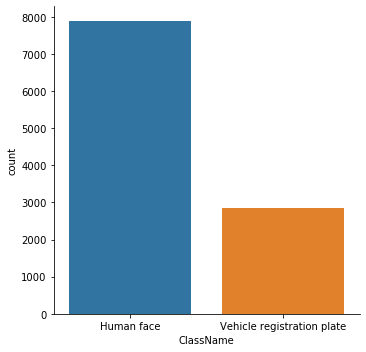

In [51]:
df_oid_test = df_oid_all[df_oid_all["set"] == "test"]
display(df_oid_test["ClassName"].value_counts())
display(df_oid_test["ClassName"].value_counts(normalize=True))
print(f"the number of images: {len(df_oid_test.index.unique())}")
sns.catplot(data=df_oid_test, x="ClassName", kind="count", order=class_order)
plt.show()

In [7]:
def yolo_labels_to_dataframe(labels_path):
    df_all = pd.DataFrame(data=None)
    for label_path in labels_path:
        image_id = os.path.splitext(os.path.basename(label_path))[0]
        df = pd.read_csv(label_path, header=None, delimiter=' ', names=['class_index', 'x_center', 'y_center', 'width', 'height'])
        df['image_id'] = image_id
        df = df.set_index('image_id')
        df_all = pd.concat([df_all, df])
    return df_all

def display_yolo_anntation(labels_dir):
    labels_all_path = [p for p in glob.glob(labels_dir + '/**', recursive=True) if re.search('.txt', p)]
    futures = []
    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        for labels_path in chunked(labels_all_path, 500):
            future = executor.submit(yolo_labels_to_dataframe, labels_path)
            futures.append(future)
    concurrent.futures.wait(futures, timeout=None)
    df_list = [future.result() for future in concurrent.futures.as_completed(futures)]
    df_all = pd.DataFrame(data=None)
    for df in df_list:
        df_all = pd.concat([df_all, df])
    return df_all

In [8]:
train_dir = "yolo/labels/train"
df_train = display_yolo_anntation(train_dir)
df_train['set'] = 'train'
print(f"the number of images: {len(df_train.index.unique())}")

the number of images: 28824


In [9]:
val_dir = "yolo/labels/val"
df_val = display_yolo_anntation(val_dir)
df_val['set'] = 'val'

In [10]:
test_dir = "yolo/labels/test"
df_test = display_yolo_anntation(test_dir)
df_test['set'] = 'test'

In [11]:
class_order = ["Human face", "Vehicle registration plate"]

Human face                    77750
Vehicle registration plate    11682
Name: class_name, dtype: int64

Human face                    0.869376
Vehicle registration plate    0.130624
Name: class_name, dtype: float64

the number of images: 37310


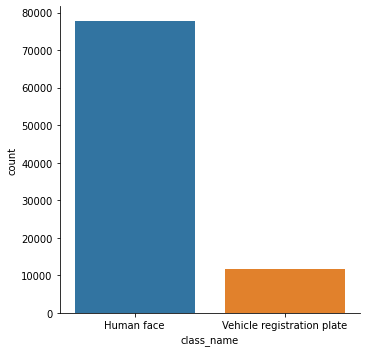

In [12]:
df_all = pd.concat([df_train, df_val, df_test])
df_all.reset_index()
df_all['class_name'] = df_all['class_index'].agg(lambda x: df_classes.loc[x, "ClassName"])
display(df_all["class_name"].value_counts())
display(df_all["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_all.index.unique())}")
sns.catplot(data=df_all, x="class_name", kind="count", order=class_order)
plt.show()

Human face                    62584
Vehicle registration plate     8000
Name: class_name, dtype: int64

Human face                    0.88666
Vehicle registration plate    0.11334
Name: class_name, dtype: float64

the number of images: 28824


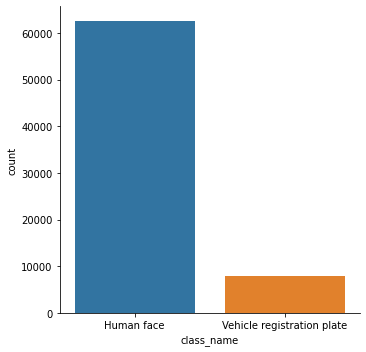

In [13]:
df_train = df_all[df_all["set"] == "train"]
display(df_train["class_name"].value_counts())
display(df_train["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_train.index.unique())}")
sns.catplot(data=df_train, x="class_name", kind="count", order=class_order)
plt.show()

Human face                    7276
Vehicle registration plate     839
Name: class_name, dtype: int64

Human face                    0.896611
Vehicle registration plate    0.103389
Name: class_name, dtype: float64

the number of images: 3203


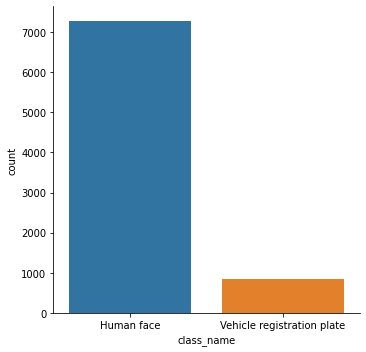

In [14]:
df_val = df_all[df_all["set"] == "val"]
display(df_val["class_name"].value_counts())
display(df_val["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_val.index.unique())}")
sns.catplot(data=df_val, x="class_name", kind="count", order=class_order)
plt.show()

Human face                    7890
Vehicle registration plate    2843
Name: class_name, dtype: int64

Human face                    0.735116
Vehicle registration plate    0.264884
Name: class_name, dtype: float64

the number of images: 5283


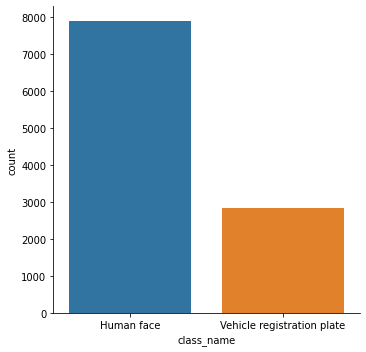

In [15]:
df_test = df_all[df_all["set"] == "test"]
display(df_test["class_name"].value_counts())
display(df_test["class_name"].value_counts(normalize=True))
print(f"the number of images: {len(df_test.index.unique())}")
sns.catplot(data = df_test, x = "class_name", kind="count", order=class_order)
plt.show()